In [1]:
## Wp2a Roast SVM analysis - Aloi Davide (PhD student - University of Birmingham)

# Imports
import warnings
warnings.filterwarnings("ignore")
import os
import glob
import numpy as np
from nilearn import image, plotting
from nilearn.image import new_img_like
from scipy import ndimage
import scipy.io
from ipywidgets import IntProgress
from IPython.display import display
import time

results_folder = 'D:\\roast-chapter3\\wp2a_results\\' # where wp2a e-field maps, current density maps and brain masks were saved

emag_scans = image.load_img(os.path.join(results_folder + 'wp2a_all_emag_maps.nii'))
cd_scans = image.load_img(os.path.join(results_folder + 'wp2a_all_cd_maps.nii'))
mask_scans = image.load_img(os.path.join(results_folder + 'wp2a_all_masks_maps.nii'))

In [11]:
## Parameters and variables: 
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' 
output_folder = 'D:\\roast-chapter3\\wp2a_results\\' # where to save e-field maps, current density maps and brain masks
verbose = False # Print each subject's output or not

# List of subjects
subjects = ['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']
#subjects = ['01','02']

## Loading DCM results 
# Day1_all_EPvalues.mat file contains 66 DCM matrices (anodal, cathodal and sham, per participant (N=22)).
# This are the results of the comparison Day-1 pre < Day-1 post, per subject, per stimulation condition (anodal, cathodal, sham)
# Connections in the matrix are (in this order): M1, Th, SMA, Cerebellum.
# The DCM quantifies the change in effective connectivity after stimulation as compared to pre stimulation.
# NB: I am interested only in anodal (indexes 0, 3, 6 ... 63) and sham (indexes 2, 5, 8... 65)
# NB: Each structure in the Day1_all_EPvalues.mat file contains an array of size 16. To get the DCM matrix,
# each array has to be reshaped (4,4) and transposed, because the DCM "thinks" columns (from) by rows (to) (rather than 
# rows x columns like everyone else in the world).
# NB: The Day_1_all_EPvalues.mat file was created with the script wp2a_roast_4_extract_single_dcms.m

dcm_data_day1_path = os.path.join(main_folder, 'wp2a_DCMfiles', 'Day1_all_EPvalues.mat') 
dcm_data_day1 = scipy.io.loadmat(dcm_data_day1_path)

## Loading AAL3 atlas and extracting M1 / Thalamus ROIs (regions of interest)
# AAL3 atlas paper: https://www.oxcns.org/papers/607%20Rolls%20Huang%20Lin%20Feng%20Joliot%202020%20AAL3.pdf 
AAl3_path = os.path.join(main_folder, 'rois', 'AAL3v1_1mm.nii')
AAL3_atlas = image.load_img(AAl3_path)

## Creating M1 and Th masks from the AAL3 atlas. Loading MNI template
# AAL3 index for left M1 = 1
m1 = image.math_img("np.where(img == 1, 1, 0)", img = AAL3_atlas) 
# AAL3 index for TH = 121 - 149 (odd values only (left thalamus))
th = image.math_img("np.where(np.isin(img, np.arange(121, 150, 2)), 1, 0)", img = AAL3_atlas) 

# MNI template for plotting and masking purposes
bg_img_map = image.load_img(os.path.join(main_folder, 'rois', 'MNI152_T1_1mm_Brain.nii'))
bg_img_map_smoothed = image.smooth_img(bg_img_map, fwhm=4) # MNI template smoothed (plotting purposes only)

## Lists where I will store each subject's results
all_dcm_matrices = np.zeros([4,4,22]) # DCM matrices for the anodal condition
all_dcm_matrices_sham = np.zeros([4,4,22]) # DCM matrices for the sham condition
thm1_labels = np.zeros([22])

In [32]:
pos_dcm_res = 0

for sbj in subjects: 
    # Loading DCM results
    # Transposing is needed because the PEB lists values column by row and not row by column...
    this_dcm = np.array(dcm_data_day1['ALLEP'][0][pos_dcm_res].todense().reshape((4,4))).T # Anodal
    this_dcm_sham = np.array(dcm_data_day1['ALLEP'][0][pos_dcm_res + 2].todense().reshape((4,4))).T  # Sham
    
    # Storing DCM matrices
    all_dcm_matrices[:,:,pos_dcm_res] = this_dcm
    all_dcm_matrices_sham[:,:,pos_dcm_res] = this_dcm_sham
    
    if this_dcm[0,1]>0: # thalamo to m1
            thm1_labels[pos_dcm_res] = 1
    
    pos_dcm_res += 1 

In [33]:
thm1_labels

array([0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1.])

In [136]:
cv = KFold(n_splits=5)
cv

KFold(n_splits=5, random_state=None, shuffle=False)

In [149]:
from nilearn.decoding import Decoder
from sklearn.model_selection import KFold
n_folds = 5
decoder = Decoder(
    estimator='svc', mask=m1,
    standardize=True, cv=n_folds,
    scoring='accuracy'
)
decoder.fit(cd_scans, thm1_labels)


In [152]:
print(decoder.cv_params_[0])

print(decoder.cv_scores_)


{'C': [100.0, 100.0, 100.0, 100.0, 100.0]}
{0.0: [0.4, 0.6, 0.25, 0.25, 0.25], 1.0: [0.4, 0.6, 0.25, 0.25, 0.25]}


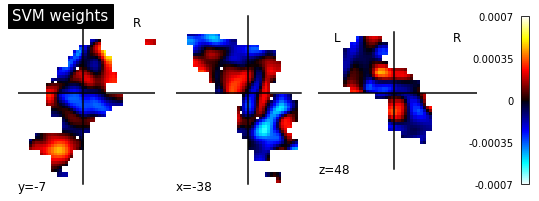

In [74]:
weight_img = decoder.coef_img_[1]
from nilearn.plotting import plot_stat_map, show
plot_stat_map(weight_img, bg_img=None, title='SVM weights')
